In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
get_ipython().run_line_magic('matplotlib', 'inline')

/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#read the datafile 
df_initial = pd.read_csv('/Users/vinoothna/Desktop/Quarter 3/PredictiveAnalytics/FinalProject/Online Retail.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

In [3]:
## DATA PREPARATION
#Checking dimensions
print('Dataframe dimensions:', df_initial.shape)

#Converting the Invoice date to dateTime format
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

Dataframe dimensions: (541909, 8)


In [4]:
# Checking the % of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


In [5]:
# Show Summary
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom


In [6]:
#dropping the 25% of null values as they are not assigned to any customer
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)



Dataframe dimensions: (406829, 8)


In [7]:
#Drop Duplicate entries
print('Duplicate Entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate Entries: 5225


In [8]:
## EXPLORATION DATA ANALYSIS


#How many countries involved?
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No of countries: {}'.format(len(countries)))



No of countries: 37


In [9]:
#Top 5 customers with most number of orders
orders = df_initial.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()
print('The TOP 5 customers with most number of orders')
orders.sort_values(by='InvoiceNo', ascending=False).head()

The TOP 5 customers with most number of orders


,CustomerID,Country,InvoiceNo
4050,17841,United Kingdom,7812
1903,14911,EIRE,5898
1308,14096,United Kingdom,5128
338,12748,United Kingdom,4459
1682,14606,United Kingdom,2759


In [10]:
#Number of orders per country?
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [11]:
#Top5 country/customer that spent the highest money
df_initial['amount_spent'] = df_initial['Quantity'] * df_initial['UnitPrice']
money_spent = df_initial.groupby(by=['CustomerID','Country'], as_index=False)['amount_spent'].sum()
print('The TOP 5 customers with highest money spent')
money_spent.sort_values(by='amount_spent', ascending=False).head()

The TOP 5 customers with highest money spent


,CustomerID,Country,amount_spent
1711,14646,Netherlands,279489.02
4241,18102,United Kingdom,256438.49
3766,17450,United Kingdom,187322.17
1903,14911,EIRE,132458.73
57,12415,Australia,123725.45


In [12]:
#What are the number of users, transactions and products in these entries ?
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [13]:
#number of products purchased in every transaction
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
no_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
no_products_per_basket[:5].sort_values('CustomerID')



,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [14]:
#observing that the invoice orders containing 'C' are cancelled orders 
no_products_per_basket['orders_cancelled'] = no_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(no_products_per_basket[:5])

#finding the % of Cancelled orders
n1 = no_products_per_basket['orders_cancelled'].sum()
n2 = no_products_per_basket.shape[0]
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,orders_cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders cancelled: 3654/22190 (16.47%) 


In [15]:
#checking the other transactions in 'StockCode'
list_special_content = df_initial[df_initial['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_content



array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [16]:
#defining these special transactions 
for code in list_special_content:
    print("{:<15} -> {:<30}".format(code, df_initial[df_initial['StockCode'] == code]['Description'].unique()[0]))



POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


In [17]:
#the transaction entries indicating a cancellation 
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

In [20]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("no of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

no of entries to delete: 8795


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent,QuantityCanceled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-01-12 09:49:00,4.65,15311,United Kingdom,-4.65,0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-01-12 10:24:00,1.65,17548,United Kingdom,-19.80,0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-01-12 10:24:00,0.29,17548,United Kingdom,-6.96,0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-01-12 10:24:00,0.29,17548,United Kingdom,-6.96,0
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-01-12 10:24:00,0.29,17548,United Kingdom,-6.96,0


In [19]:
#Deleting the cancellation entries which don'thave related command beforehand
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent,QuantityCanceled


In [21]:
#Introducing a new variable- Basket price, that indicates the total price of every purchase
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,0,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6,0,-77183.6
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-02-08 08:48:00,4.25,12347,Iceland,17.0,0,17.0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland,13.2,0,13.2
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-07-12 14:57:00,1.25,12347,Iceland,15.0,0,15.0


In [22]:
#Finding the total sum of purchases by collecting all the purchases made during a single order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of entries
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
 
#selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,77183.60,2011-01-18 10:01:00.000000000
2,12347,537626,711.79,2010-07-12 14:57:00.000001024
3,12347,542237,475.39,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,2011-07-04 10:42:59.999999232
5,12347,556201,382.52,2011-09-06 13:01:00.000000256
6,12347,562032,584.91,2011-02-08 08:48:00.000000000


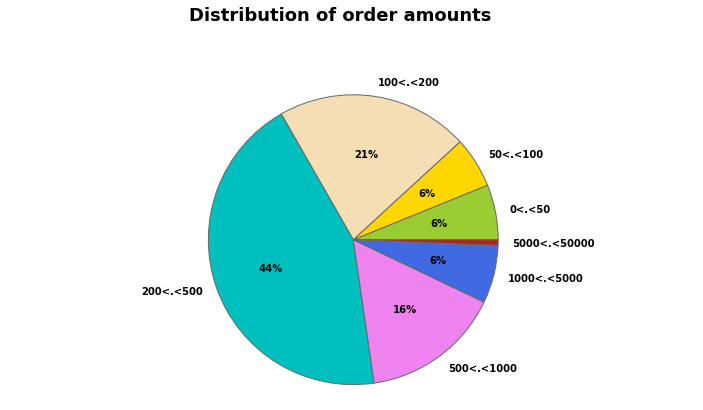

In [23]:
#purchase count 
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount   
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);


In [25]:
#Extract names from product desciptions by aggregating their rootwords
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("No of keywords in a variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords


In [27]:
#dataframe to retreive the list of products
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [33]:
#analysing description 
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

No of keywords in a variable 'Description': 1483


In [29]:
import nltk

In [30]:
 nltk.download('punkt')
    

[nltk_data] Downloading package punkt to /Users/vinoothna/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [32]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vinoothna/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [34]:
#converting the count_keywords dictionary into a list, to sort the keywords according to their occurences
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

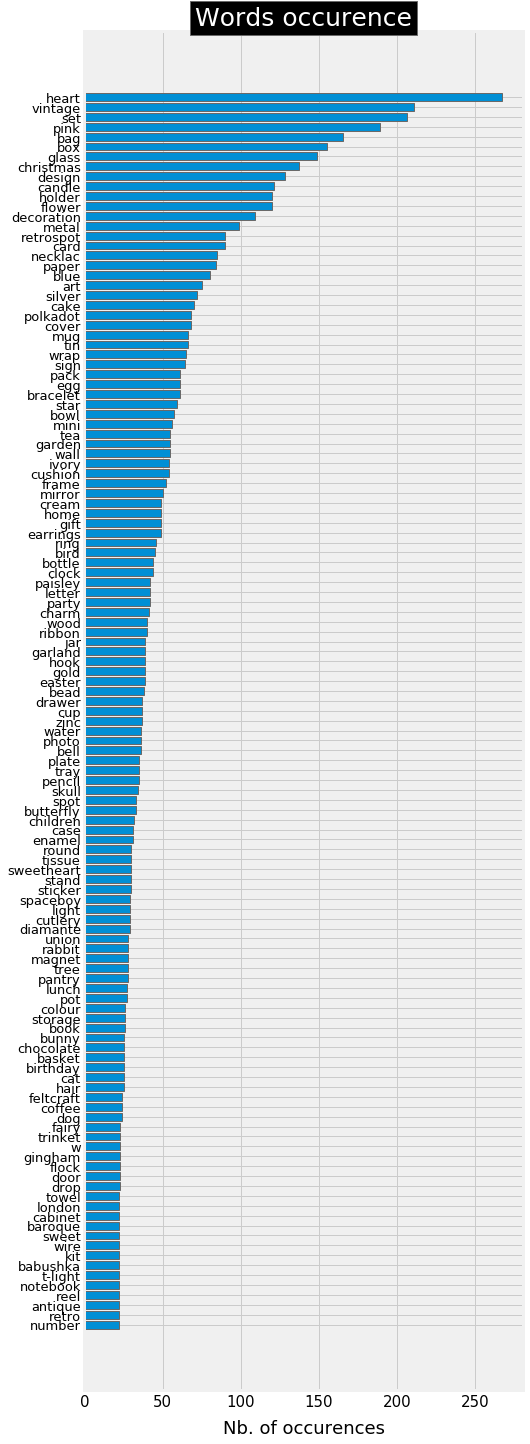

In [35]:
#plotting word occurence according to their importance
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [45]:
#Defining product categories with the obtained '1483' keywords obtained
#Discarding keywords like colours that don't carry much information about a customer
#Also keeping the keywords that have appeared more than 13 times
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))


mots conservés: 193


In [46]:
#One hot encoding using a matrix X based on if the product description contains a keyword or otherwise.
liste_products = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_products))

In [47]:
#Adding Price range as 6 extra columns for more balanced clusters
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_products):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [48]:
#Price range of products
print("{:<8} {:<20} \n".format('Range', 'no. of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range    no. of products      
--------------------
0<.<1       965                 
1<.<2       1013                
2<.<3       674                 
3<.<5       611                 
5<.<10      476                 
.>10        157                 


In [51]:
matrix = X.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

/Users/vinoothna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



For n_clusters = 2 The average silhouette_score is : 0.06930407283158414
For n_clusters = 3 The average silhouette_score is : 0.10150779068464941
For n_clusters = 4 The average silhouette_score is : 0.12673477668888355
For n_clusters = 5 The average silhouette_score is : 0.14758138929669556
For n_clusters = 6 The average silhouette_score is : 0.14351836732994228
For n_clusters = 7 The average silhouette_score is : 0.15832746171877818
For n_clusters = 8 The average silhouette_score is : 0.14951269527836936
For n_clusters = 9 The average silhouette_score is : 0.15357179359441733


In [52]:
#based on the silhoutte score we can pick the clusters which have a balanced class - 5 clusters
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14579729104882663


In [53]:
#Sanity check ensuring balanced clusters
pd.Series(clusters).value_counts()

0    1167
3     965
1     674
4     611
2     479
dtype: int64

In [54]:
##Customer Categories
#creating a categorical variable to indicate the cluster of each product 
corresp = dict()
for key, val in zip (liste_products, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [55]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.3,0.0,0.0,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.0,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.0,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.0,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.0,0.0,0.0,20.34


In [56]:
#sum of purchases 
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# percentage of the order price 
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12346,541431,77183.60,77183.60,0.00,0.00,0.00,0.00,2011-01-18 10:01:00.000000000
2,12347,537626,711.79,187.20,83.40,124.44,23.40,293.35,2010-07-12 14:57:00.000001024
3,12347,542237,475.39,168.75,53.10,0.00,84.34,169.20,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,369.15,71.10,0.00,81.00,115.00,2011-07-04 10:42:59.999999232
5,12347,556201,382.52,74.40,78.06,19.90,41.40,168.76,2011-09-06 13:01:00.000000256


In [57]:
#seperating data over time
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-01-12 08:26:00 -> 2011-12-10 17:18:59.999999488


In [58]:
#total amount spent during all the visits & number of purchases made by a consumer
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12346,1,77183.60,77183.60,77183.600000,77183.60,100.000000,0.000000,0.000000,0.000000,0.000000
1,12347,7,224.82,1294.32,615.714286,4310.00,30.813225,20.805104,7.604176,11.237123,29.540371
2,12348,4,227.44,892.80,449.310000,1797.24,61.983931,0.000000,0.000000,38.016069,0.000000
3,12349,1,1757.55,1757.55,1757.550000,1757.55,52.138488,12.245455,20.389178,4.513101,10.713778
4,12350,1,334.40,334.40,334.400000,334.40,60.406699,27.900718,0.000000,11.692584,0.000000


In [59]:
#adding 2 variables 'the number of days elapsed since the first purchase'&'number of days since the last purchase'
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12346,1,77183.60,77183.60,77183.600000,77183.60,100.000000,0.000000,0.000000,0.000000,0.000000,326,326
1,12347,7,224.82,1294.32,615.714286,4310.00,30.813225,20.805104,7.604176,11.237123,29.540371,40,516
2,12348,4,227.44,892.80,449.310000,1797.24,61.983931,0.000000,0.000000,38.016069,0.000000,76,359
3,12349,1,1757.55,1757.55,1757.550000,1757.55,52.138488,12.245455,20.389178,4.513101,10.713778,19,19
4,12350,1,334.40,334.40,334.400000,334.40,60.406699,27.900718,0.000000,11.692584,0.000000,311,311


In [60]:
#Customers we want to retain ie. the customers that made only one purchase
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("no. of customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

no. of customers with single purchase: 1493/4338  (34.42%)


In [61]:
#Summary of the transactions corresponding to a particular client
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

/Users/vinoothna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [62]:
#Data Encoding
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.27201475 262.3719207  653.64825081 417.64573488  32.72541129
  21.52474433  14.88333953  13.90376256  16.96274229]


In [65]:
#Defining clusters of clients from k-means algorithm
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)

#Using best Silhouette scores we choose the no of Final clusters
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.207


In [67]:
#the number of customers in each cluster
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['no. of clients']).T

,0,5,6,7,9,1,2,8,10,3,4
no. of clients,1532,1013,552,342,329,276,151,134,7,1,1


In [71]:
#Plotted Quality of seperation using Intra-cluster Silhoutte scores 
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  



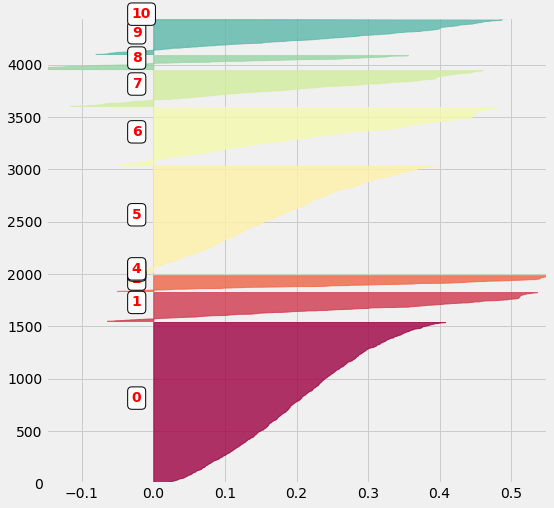

In [72]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#Plot
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [73]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [74]:
#average the contents of this dataframe by first selecting the different groups of clients
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 4338


In [75]:
#re-organize the content of the dataframe 
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,6.0,2.652174,241.017047,416.698514,317.488388,902.506415,66.817237,10.043995,7.116916,8.704657,7.317195,552
1,1.0,3.021739,245.161957,463.844348,346.686429,1061.391341,14.688062,66.432919,5.290816,6.443380,7.144823,276
2,2.0,2.827815,276.709272,420.235033,340.274045,946.093179,11.225376,7.613213,69.911893,3.515429,7.734089,151
3,7.0,2.459064,223.085000,382.785906,288.686101,801.736404,24.082670,11.603698,5.873170,51.276026,7.164437,342
4,9.0,2.702128,254.419818,446.801520,339.382908,1032.346717,17.057351,13.738176,9.527136,6.830947,52.846390,329
5,5.0,3.495558,249.413309,509.789913,364.987516,1254.752372,27.713101,18.260453,27.330033,8.392860,18.303553,1013
6,0.0,3.947781,254.789014,584.035431,402.146689,1550.871266,34.647586,24.505682,8.870475,15.258177,16.718080,1532
7,8.0,26.746269,115.125597,3459.289776,963.181040,23035.710672,29.850203,26.579070,15.514267,10.774616,17.281844,134
8,10.0,128.714286,10.744286,2252.004286,390.279712,51420.727143,32.748337,22.073250,17.367632,13.610606,14.200175,7
9,4.0,1.000000,77183.600000,77183.600000,77183.600000,77183.600000,100.000000,0.000000,0.000000,0.000000,0.000000,1


In [77]:
#define a class that allows to interface several of the functionalities common to these different classifiers
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [78]:
#only keeping the varaiables that describe the basket content
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [79]:
#Splitting the dataset in train and test sets
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [81]:
##DATA MODELLING
#LOGISTIC REGRESSION
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Precision: 89.17 % 


In [85]:
#Logistic regression Plot 
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt



/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



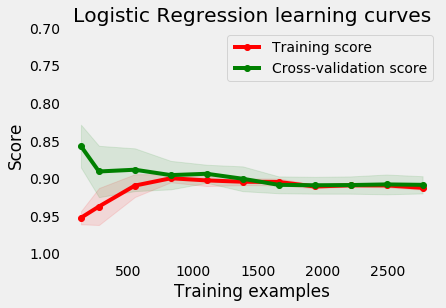

In [86]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [87]:
#k-Nearest Neighbors
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Precision: 80.76 % 


/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



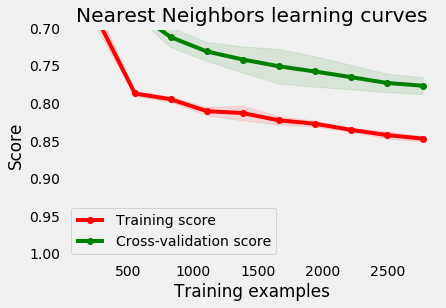

In [88]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [89]:
#Decision Tree
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Precision: 87.33 % 


/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



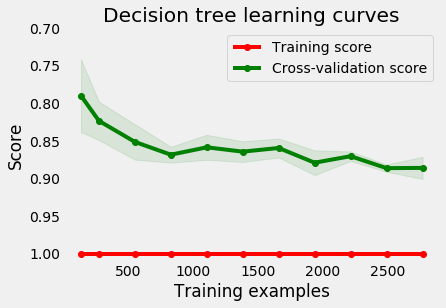

In [90]:
#Decision Tree plot
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


In [91]:
#Random Forest
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Precision: 92.63 % 


/Users/vinoothna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



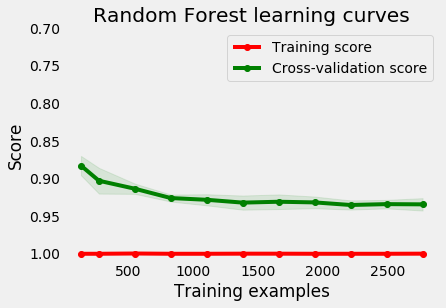

In [92]:
#Random forest Plot
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])